### Introduction

Link prediction demo for cora dataset (homegeneous network) where all nodes are papers and edges between nodes are citation links, e.g., paper A cites paper B. 

Each paper has a **subject** attribute with one of 7 values denoting the subject area of the paper.

This demo notebook **demonstrates how to predict citation links between papers** using the random walk-based representation learning method Node2Vec.

**(Cite Node2Vec paper)**

In [10]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.manifold import TSNE
import os
import networkx as nx
import numpy as np
from stellar.data.edge_splitter import EdgeSplitter
from utils.cl_arguments_parser import parse_args
from utils.read_graph import read_graph
from utils.predictors import *
from collections import Counter
import multiprocessing

In [3]:
# Default parameters for Node2Vec
parameters = {
    "p": 1.,  # Parameter p
    "q": 1.,  # Parameter q
    "dimensions": 128,  # dimensionality of node2vec embeddings
    "num_walks": 10,  # Number of walks from each node
    "walk_length": 80,  # Walk length
    "window_size": 10,  # Context size for word2vec
    "iter": 1,  # number of SGD iterations (epochs)
    "workers": multiprocessing.cpu_count(),  # number of workers for word2vec
    "weighted": False,  # is graph weighted?
    "directed": False,  # are edges directed?
}

### Load the dataset

In [15]:
cora_epgm_location = os.path.expanduser("~/Projects/data/cora/cora.epgm/")
dataset_name = 'cora'
g_nx = read_graph(graph_file=cora_epgm_location, dataset_name=dataset_name)

# Select the largest connected component. For clarity we ignore isolated
# nodes and subgraphs; having these in the data does not prevent the
# algorithm from running and producing valid results.
g_nx = max(nx.connected_component_subgraphs(g_nx, copy=True), key=len)
print("Largest subgraph statistics: {} nodes, {} edges".format(
    g_nx.number_of_nodes(), g_nx.number_of_edges()))


...reading /Users/eli024/Projects/data/cora/cora.epgm/graphs.json using utf-8 encoding...
...reading /Users/eli024/Projects/data/cora/cora.epgm/vertices.json using utf-8 encoding...
...reading /Users/eli024/Projects/data/cora/cora.epgm/edges.json using utf-8 encoding...
Converting the EPGM graph 9ccd0dd106204767a723747a8b8d5b8a to NetworkX graph...
Graph statistics: 2708 nodes, 5278 edges
Largest subgraph statistics: 2485 nodes, 5069 edges


### Construct train and test splits of the input data

In [16]:
# Test graph and edge test data
edge_splitter_test = EdgeSplitter(g_nx)
g_test, edge_data_ids_test, edge_data_labels_test = edge_splitter_test.train_test_split( 
    p=0.1, method='global'
)

# Train graph and edge train data
edge_splitter_train = EdgeSplitter(g_test, g_nx)
g_train, edge_data_ids_train, edge_data_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method='global'
)

** Sampled 258 positive and 258 negative edges. **
** Sampled 232 positive and 232 negative edges. **


In [17]:
# Train and Test graphs should be of type nx.Graph
g_test = nx.Graph(g_test)
g_train = nx.Graph(g_train)

### Train the link prediction model and evaluate on test data

In [18]:
train_fl, test_fl, clf_edge = train_homogeneous_graph(
    g_train=g_train,
    g_test=g_test,
    output_node_features='embeddings.emb',
    edge_data_ids_train=edge_data_ids_train,
    edge_data_labels_train=edge_data_labels_train,
    edge_data_ids_test=edge_data_ids_test,
    edge_data_labels_test=edge_data_labels_test,
    parameters=parameters,
)

(Node2VecFeatureLearning) Time for random walks 10 seconds
(Node2VecFeatureLearning) Time for learning embeddings 8 seconds.
Total time for fit() 18.35250210762024 seconds
Operator: h Score (on test set of edge_data): 0.8909796893667861
Operator: avg Score (on test set of edge_data): 0.5403726708074534
Operator: l1 Score (on test set of edge_data): 0.9164404223227752
Operator: l2 Score (on test set of edge_data): 0.9467895362663495
(Node2VecFeatureLearning) Time for random walks 10 seconds
(Node2VecFeatureLearning) Time for learning embeddings 8 seconds.
Total time for fit() 18.537127017974854 seconds
Prediction score: 0.95903190914

  **** Scores on test set ****

     Operator: l2  Score: 0.96

  ****************************


### Visualise representations of edge data

Learned edge embeddings have 128 dimensions but for visualisation we project them down to 2 dimensions. Green points represent positive edges and red points represent negative (no edge should exist between the corresponding vertices) edges.

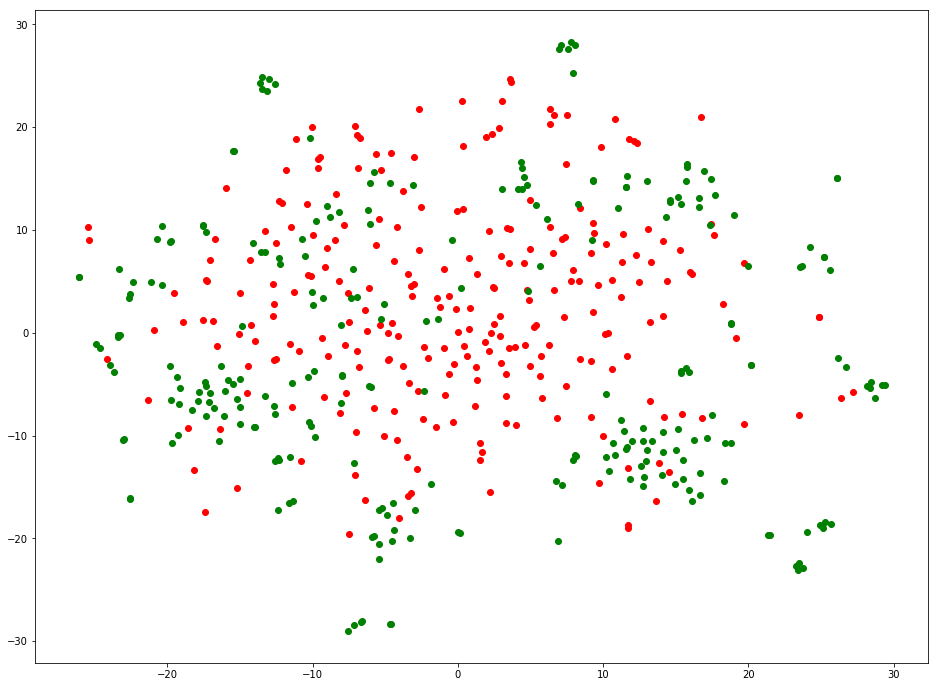

In [19]:
# Calculate edge features for test data
edge_data = (edge_data_ids_test, edge_data_labels_test)
X, y = test_fl.transform(edge_data, 'h')

# Learn a projection from 128 dimensions to 2
tsne = TSNE(n_components=2, init='random', random_state=0)
X_transformed = tsne.fit_transform(X)

# plot the 2-dimensional points
red = y == 0
green = y == 1
plt.figure(figsize=(16,12))
plt.scatter(X_transformed[red, 0], X_transformed[red, 1], c="r")
plt.scatter(X_transformed[green, 0], X_transformed[green, 1], c="g")

In [20]:
# collect the nodes in edge_data_ids
nodes = { u for u in edge_data_ids_test.flatten()}
# create subgraph using only the above nodes
g_test_subgraph = g_test.subgraph(nodes)
print("Nubmer of nodes in subgraph {} vs {} in full graph".format(g_test_subgraph.number_of_nodes(), g_test.number_of_nodes()))
print("Nubmer of edges in subgraph {} vs {} in full graph".format(g_test_subgraph.number_of_edges(), g_test.number_of_edges()))

Nubmer of nodes in subgraph 808 vs 2485 in full graph
Nubmer of edges in subgraph 825 vs 4811 in full graph


['1123689' '1105810'] 0


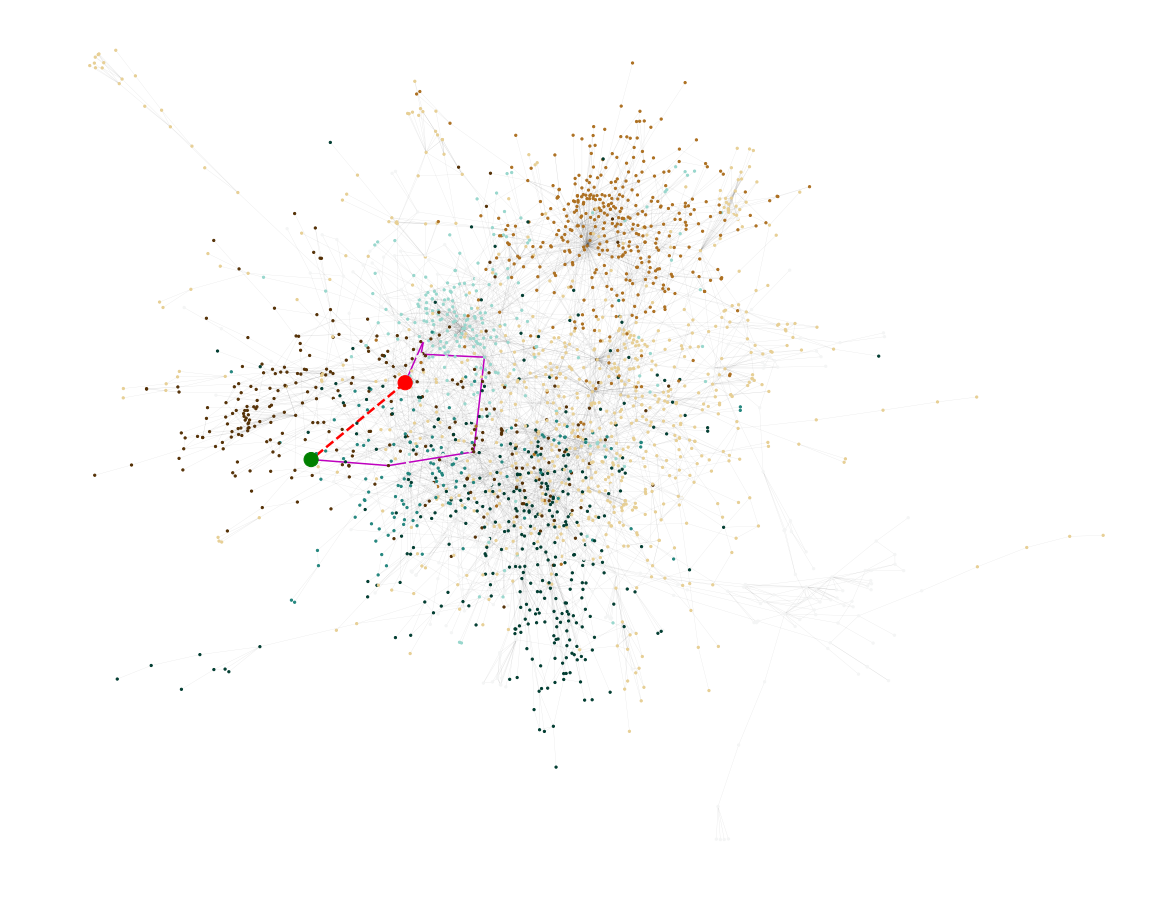

In [21]:
np.random.seed(seed=42)

node_labels = [ n[1]['subject'] for n in g_nx.nodes(data=True) ]
ulabels = np.unique(node_labels)
label_map = { l: i for i, l in enumerate(ulabels)}
node_colours = [ label_map[nl]/7. for nl in node_labels]

# layout
pos = nx.spring_layout(g_nx)

# draw the test graph
plt.figure(figsize=(20,16))
nx.draw_networkx(g_nx, pos=pos, with_labels=False, node_size=5, edgelist=[],
                node_color=node_colours, cmap=plt.cm.BrBG)

# draw the edges in the full graph
nx.draw_networkx(g_nx, with_labels=False, pos=pos, nodelist=[], 
                 edgelist=list(g_nx.edges()), alpha=0.1, width=0.3 )


# collect the nodes in the positive and negative edge samples
nodes = list({u for u in edge_data_ids_test.flatten() })

edge_index = -1

nx.draw(g_nx, pos=pos, node_size=200, 
        nodelist=[edge_data_ids_test[edge_index][0], edge_data_ids_test[edge_index][1]], 
        edgelist=[], with_labels=False, width=0.5, node_color=['r', 'g'])

path = nx.shortest_path(g_nx, source=edge_data_ids_test[edge_index][0],
                        target=edge_data_ids_test[edge_index][1])
path_edges = list(zip(path,path[1:]))
nx.draw_networkx_edges(g_nx, pos, edgelist=path_edges, edge_color='m',width=1.5)

# Use the trained classifier to make a prediction
print(edge_data_ids_test[edge_index], edge_data_labels_test[edge_index])
y_pred = predict(feature_learner=test_fl, 
                 edge_data=([edge_data_ids_test[edge_index]], 
                            [edge_data_labels_test[edge_index]]), 
                            clf=clf_edge, binary_operators=['h'])

if edge_data_labels_test[edge_index] == 0:  # negative edge so draw a dashed edge
    link_style = 'dashed'
    if y_pred['h'][0][0] > 0.5:  # correctly predicted no edge
        # draw green dashed line between the source and target nodes
        link_color = 'g'
    else:  # incorrectly predicted an edge
        # draw a red dashed line between the source and target nodes
        link_color = 'r'
else:  # positive edge so draw a solid edge
    link_style = 'solid'
    if y_pred['h'][0][1] > 0.5:  # correctly predicted and edge
        # draw green solid line between the source and target nodes
        link_color = 'g'
    else:  # incorrectly predicted no edge
        # draw a red solid line between the source and target nodes
        link_color = 'r'

nx.draw_networkx_edges(g_nx, pos=pos, 
                       edgelist=[(edge_data_ids_test[edge_index][0], edge_data_ids_test[edge_index][1]),], 
                       with_labels=False, width=2.5, edge_color=link_color, style=link_style)

    

In [22]:
edge_data_ids_test[edge_index]

array(['1123689', '1105810'], dtype=object)

In [23]:
edge_index = -1
print(edge_data_ids_test[edge_index], edge_data_labels_test[edge_index])
y_pred = predict(feature_learner=test_fl, 
        edge_data=([edge_data_ids_test[edge_index]], [edge_data_labels_test[edge_index]]), 
        clf=clf_edge, binary_operators=['h'])

['1123689' '1105810'] 0


In [24]:
pr = predict(feature_learner=test_fl, 
             edge_data=(edge_data_ids_test, edge_data_labels_test), 
             clf=clf_edge, binary_operators=['h'])

In [27]:
y_pred['h'][0]

array([ 0.44196857,  0.55803143])